In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [2]:
# Step 1: Create a directory for storing downloaded .nc files
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

In [3]:
# Step 2: Scrape the website for .nc file links
url = "https://noaadata.apps.nsidc.org/NOAA/G02202_V4/north/monthly/"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

In [4]:
# Step 3: Find all links ending with .nc
nc_links = []
for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.nc'):
        nc_links.append(url + href)  # Construct the full URL

In [5]:
# Step 4: Download the .nc files into the data directory
for nc_url in nc_links:
    filename = os.path.join(data_dir, nc_url.split('/')[-1])
    
    response = requests.get(nc_url)
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f'Downloaded {filename}')

Downloaded data/seaice_conc_monthly_nh_197811_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197812_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197901_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197902_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197903_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197904_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197905_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197906_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197907_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197908_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197909_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197910_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197911_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_197912_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_198001_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_198002_n07_v04r00.nc
Downloaded data/seaice_conc_monthly_nh_1

In [6]:
# Step 5: Combine the .nc files
nc_files = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.nc')]

# Prepare an empty list to store the modified datasets
datasets = []

# Define time points (adjust according to your actual time steps)
time_points = pd.date_range(start='1978-11-01', periods=len(nc_files), freq='MS')

# Loop through each file, open it, and assign a time coordinate
for i, nc_file in enumerate(nc_files):
    # Open the dataset
    ds = xr.open_dataset(nc_file)
    
    # Assign a time coordinate
    ds = ds.assign_coords(time=time_points[i])  # Assign the unique time coordinate
    ds = ds.expand_dims(dim='time')  # Expand to add time dimension of size 1
    
    # Append the modified dataset to the list
    datasets.append(ds)

In [7]:
# Step 6: Concatenate the datasets along the time dimension
combined_ds = xr.concat(datasets, dim='time')

# Step 6a: Drop the 'tdim' dimension
combined_squeezed = combined_ds.squeeze('tdim')

# Step 6b: Replace xgrid and ygrid with lat and lon
combined_renamed = combined_squeezed.rename({'x': 'lon', 'y': 'lat'})
combined_dropped = combined_renamed.drop_vars(['xgrid', 'ygrid'], errors='ignore')
combined_gridded = combined_dropped.assign_coords(lon=np.linspace(-180, 180, 304), lat=np.linspace(31.35, 90, 448))

# Step 6c: Rename the 'cdr_seaice_conc_monthly' variable
combined_cleaned = combined_gridded.rename({'cdr_seaice_conc_monthly': 'monthly_sic'})

In [9]:
# Step 7: Save the combined dataset to a new .nc file
output_filename = 'noaav4_nh_monthly_sic_1978_2024.nc'
combined_cleaned.to_netcdf(output_filename)
print(f'Saved combined dataset to {output_filename}')

Saved combined dataset to noaav4_nh_monthly_sic_1978_2024.nc


In [10]:
# Step 8: Check output of combined data file
ds_test = xr.open_dataset('noaav4_nh_monthly_sic_1978_2024.nc')
ds_test

<xarray.Dataset> Size: 2GB
Dimensions:                                 (time: 545, lat: 448, lon: 304)
Coordinates:
  * time                                    (time) datetime64[ns] 4kB 1978-11...
  * lon                                     (lon) float64 2kB -180.0 ... 180.0
  * lat                                     (lat) float64 4kB 31.35 ... 90.0
Data variables:
    monthly_sic                             (time, lat, lon) float32 297MB ...
    melt_onset_day_cdr_seaice_conc_monthly  (time, lat, lon) float32 297MB ...
    nsidc_bt_seaice_conc_monthly            (time, lat, lon) float32 297MB ...
    nsidc_nt_seaice_conc_monthly            (time, lat, lon) float32 297MB ...
    projection                              (time) |S1 545B ...
    qa_of_cdr_seaice_conc_monthly           (time, lat, lon) float32 297MB ...
    stdev_of_cdr_seaice_conc_monthly        (time, lat, lon) float32 297MB ...
Attributes: (12/41)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc_monthly
    metadata_link:             https://nsidc.org/data/g02202/versions/4/
    ...                        ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-22T16:08:07Z
    time_coverage_start:       1987-04-01T00:00:00Z
    time_coverage_end:         1987-04-30T23:59:59Z
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...

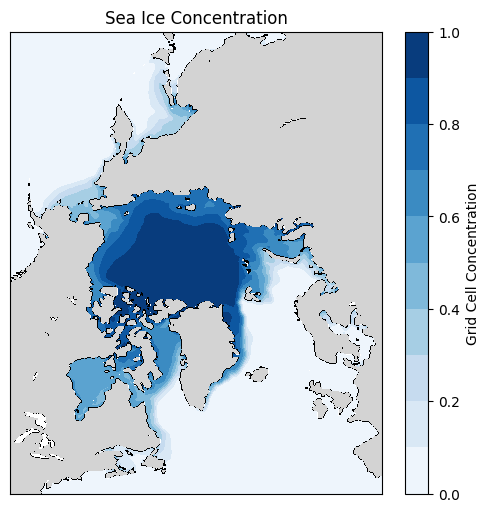

In [48]:
# Now we can analyze the data in this xarray dataset

# For example, we can calculate the mean sea ice concentration over time
sic = ds_test['monthly_sic'].mean(dim='time')
# Or select the first month/specific month and year
# sic = ds_test['monthly_sic'].isel(time=0)
# Or Find the difference between the first and last Januaries
# sic = ds_test['monthly_sic'].sel(time=ds_test['time.month']==1).diff(dim='time').isel(time=-1)

# Get the land mask
sic_masked = sic.where(sic <= 1.0)
sic_nan = sic.where(sic > 1.0)

# Plot the sea ice concentration
plt.figure(figsize=(6, 6))

# Add the sea ice concentration
plt.contourf(sic_masked, levels=np.linspace(0, 1, 11), cmap='Blues', origin='upper')

# Add a colorbar
plt.colorbar(label='Grid Cell Concentration')

# Remove x and y labels
plt.gca().set_xticks([])
plt.gca().set_yticks([])

# Add a custom colormap for the land and other mask values
custom_cmap = ListedColormap(['white', 'k', 'k', 'lightgrey'])

# Add the land and other mask values
plt.contourf(sic_nan, levels=4, cmap=custom_cmap, origin='upper')

# Add a title
plt.title('Sea Ice Concentration')

# Show the plot
plt.show()

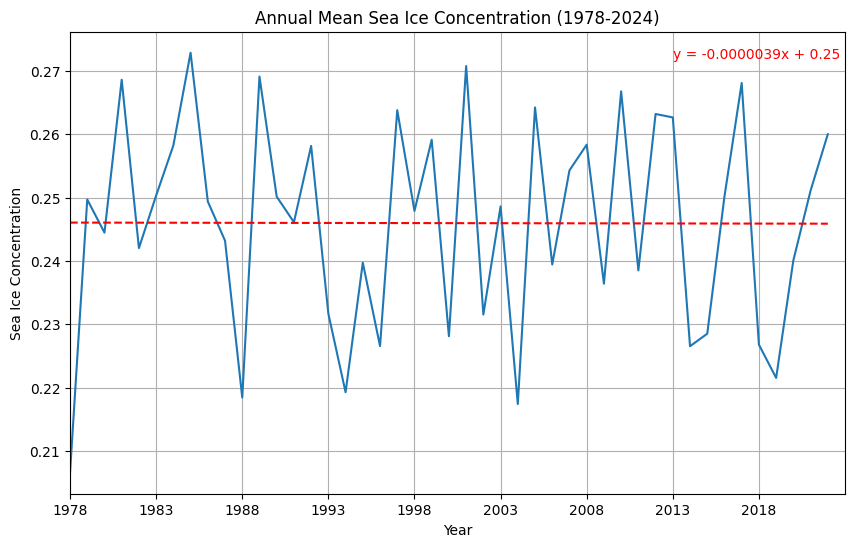

In [94]:
# We can also calculate the annual mean sea ice concentration
# Note we will adjust the data to plot complete years, so we cut off first two and last three months
sic = ds_test['monthly_sic'][2:-3].values

# Now we want the mean sea ice concentration where the concentration is less than or equal to 1.0
sic = np.where(sic <= 1.0, sic, np.nan)

# Reshape the first dimesnion to represent years and months (45, 12)
sic = sic.reshape(-1, 12, 448, 304)

# Take the mean of the sea ice concentration each year
annual_mean_sic = np.nanmean(sic, axis=(1, 2, 3))

# Plot the annual mean sea ice concentration
plt.figure(figsize=(10, 6))

# Plot the annual mean sea ice concentration
plt.plot(annual_mean_sic)

# Add a linear trend
trend = np.polyfit(range(len(annual_mean_sic)), annual_mean_sic, 1)  # Plot a linear trend on top of the data

# Add the linear trend to the plot
plt.plot(range(len(annual_mean_sic)), np.polyval(trend, range(len(annual_mean_sic))), 'r--')

# Show the linear trend equation
plt.text(35, 0.272, f'y = {trend[0]:.7f}x + {trend[1]:.2f}', color='red')

# Adjust the x tick labels so they begin at 1978
plt.xticks(range(0, len(annual_mean_sic), 5), range(1978, 2023, 5))

# Add a title and labels
plt.title('Annual Mean Sea Ice Concentration (1978-2024)')
plt.xlabel('Year')
plt.ylabel('Sea Ice Concentration')

# Add a grid
plt.xlim(0, len(annual_mean_sic))
plt.grid()

# Show the plot
plt.show()